<a href="https://colab.research.google.com/github/Bovi-analytics/Salamone-et-al-2025/blob/main/RuminatingTime_DaysInMilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for rumination time MonthsInMilk

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
.packages <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",
                  "tibble",
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car",
                  "stringr",
                  "cAIC4",
                  "ggrepel",
                  "geomtextpath",
                  "grid",
                  "sandwich",
                  "clubSandwich",
                  "skimr",
                  "purrr",
                  'cowplot',
                  "ggpubr"
                  )



# Install CRAN packages (if not already installed)
.inst <- .packages %in% installed.packages(lib.loc=lib_loc)
if(length(.packages[!.inst]) > 0) install.packages(.packages[!.inst], lib=lib_loc, repos = "http://cran.us.r-project.org")

# Load packages into session
lapply(.packages, require, character.only=TRUE, lib.loc = lib_loc, quietly = TRUE)

Attaching package: ‘dplyr’



    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



    filter, lag



    intersect, setdiff, setequal, union


Attaching package: ‘Matrix’



    expand, pack, unpack


Attaching package: ‘lmerTest’



    lmer



    step


Attaching package: ‘MASS’



    select


Attaching package: ‘TH.data’



    geyser


Caution: You lose important information if you filter this package's results.
See '? untidy'

Users are encouraged to switch the rest of the way.
See help('transition') for more information, including how to
convert old 'lsmeans' objects and scripts to work with 'emmeans'.

Attaching package: ‘car’



    recode


Attaching package: ‘nlme’



    lmList



    collapse


  method    from    
  bread.mlm sandwich

Attaching package: ‘purrr’



    some



    compact


Attaching package: ‘ggpubr’



    get_legend



    mutate




[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

[[23]]
[1] TRUE

[[24]]
[1] TRUE

[[25]]
[1] TRUE

[[26]]
[1] TRUE

[[27]]
[1] TRUE



## Data loading into dataframe

In [ ]:
%%R
MrtData <-
  readr::read_csv(
      "/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/NextMilkPredictions.csv",
      col_types = readr::cols(
          HerdId = readr::col_character(),
          AnimalId = readr::col_character()
          )
   ) %>%
  dplyr::filter(AmountMPRNext > 0.0) %>%
  dplyr::filter(DimMPRNext < 45) %>%
  dplyr::filter(DimMPRNext > 5) %>%
  dplyr::mutate(
      AnimalIdentifier = factor(AnimalId),
      CalvingDate = CalvingDateNext,
      MRT = AmountMPRNext - prediction,
      LactationNumber = lactationNumber + 1,
      HerdIdentifier = factor(case_when(
          HerdId == "287359"  ~ "3",
          HerdId == "269621" ~ "2746",
          HerdId == "6177195" ~ "2514",
          HerdId == "410638" ~ "3314",
          HerdId == "2209799" ~ "544",
          HerdId == "196062" ~ "700",
          HerdId == "325565" ~ "2011",
          HerdId == "207456" ~ "2297",
          TRUE ~  "UnknownUBN"
      ))) %>%
      group_by(HerdId) %>%
      mutate( MRTQuantile = case_when(
          MRT < quantile(MRT, probs= 0.33) ~ "LOW MRT",
          MRT <= quantile(MRT, probs= 0.66) ~ "MED MRT",
          MRT > quantile(MRT, probs= 0.66) ~ "HIGH MRT",
          TRUE ~"Missing")
      ) %>%  ungroup() %>%
  dplyr::select(
      "AnimalIdentifier",
      "HerdIdentifier",
      #"LactationNumber",
      "CalvingDate",
      "MRT",
      "MRTQuantile",
      "AmountMPRNext"
  )



In [ ]:
%%R
BehaviorData <-
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAndCalvingDataRepartitioned08032021/ObservationType=RuminationTimeMinutesPerDay/part-00000-tid-3815821870089910923-ec384d9a-727d-46aa-970e-588ecba307c7-410-32.c000.csv",
    col_types = readr::cols(HerdIdentifier = readr::col_character(),
        TransitionLactationNumber = readr::col_integer(),
        TransitionParity = readr::col_character(),
        TransitionMonthsInMilk = readr::col_integer(),
        TransitionDaysInMilk = readr::col_integer(),
        TransitionCalvingDate = readr::col_character(),
        ##Hour = readr::col_integer(),
        Observations = readr::col_integer())) %>%
  dplyr::filter(dplyr::between(TransitionDaysInMilk, -21, 21)) %>%
  dplyr::filter(TransitionDaysInMilk != 0 )%>%
  dplyr::mutate(
    CalvingDate = as.Date(TransitionCalvingDate),
    AnimalIdentifier = factor(str_replace_all(TransitionAnimalEartag, "[^0-9.]", "")),
    HerdIdentifier = factor(HerdIdentifier),
    LactationIdentifier = factor(paste(AnimalIdentifier,CalvingDate,sep="-")),
    Parity = factor(TransitionParity),
    LactationNumber = factor(TransitionLactationNumber),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    DaysInMilk = factor (TransitionDaysInMilk),
    numMonthsInMilk = TransitionMonthsInMilk,
    numDaysInMilk = TransitionDaysInMilk,
    CalvingSeason = factor(TransitionSeason),
    ##Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS")),
    CalvingGroup = factor(case_when(
          TransitionDaysInMilk <= -1 ~ "PreCalving",
          TransitionDaysInMilk >= 1 ~ "PostCalving",
          TRUE ~ "Missing"))) %>%
  dplyr::select(
      AnimalIdentifier,
      HerdIdentifier,
      LactationIdentifier,
      Parity,
      MonthsInMilk,
      DaysInMilk,
      CalvingGroup,
      numMonthsInMilk,
      numDaysInMilk,
      CalvingSeason,
      CalvingDate,
      ##Hour,
      SensorValue,
      MilkingType,
      LactationNumber
      ) %>%
  tidyr::drop_na()

In [ ]:
%%R
AnalysisData <- BehaviorData %>%
  dplyr::inner_join(
      MrtData,
      by = c("HerdIdentifier", "AnimalIdentifier", "CalvingDate")
  )

In [ ]:
%%R
AnalysisData %>%
group_by(CalvingGroup)%>%
dplyr::summarise(Mean=mean(SensorValue, na.RM=TRUE), sd=sd(SensorValue))

# A tibble: 2 × 3
  CalvingGroup  Mean    sd
  <fct>        <dbl> <dbl>
1 PostCalving   533.  109.
2 PreCalving    498.  112.


In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 × 17
  AnimalIdentifier HerdIdentifier LactationIdentifier  Parity MonthsInMilk
  <fct>            <fct>          <fct>                <fct>  <fct>       
1 919206098        2746           919206098-2017-12-04 3+     0           
2 919206098        2746           919206098-2017-12-04 3+     0           
3 919206098        2746           919206098-2017-12-04 3+     0           
4 919206098        2746           919206098-2017-12-04 3+     0           
5 919206098        2746           919206098-2017-12-04 3+     0           
6 919206098        2746           919206098-2017-12-04 3+     1           
# ℹ 12 more variables: DaysInMilk <fct>, CalvingGroup <fct>,
#   numMonthsInMilk <int>, numDaysInMilk <int>, CalvingSeason <fct>,
#   CalvingDate <dttm>, SensorValue <dbl>, MilkingType <fct>,
#   LactationNumber <fct>, MRT <dbl>, MRTQuantile <chr>, AmountMPRNext <dbl>


In [ ]:

%%R
AnalysisData$MRTQuantile = factor(AnalysisData$MRTQuantile)
AnalysisData$MRTQuantile = relevel(AnalysisData$MRTQuantile,ref = "LOW MRT")

In [ ]:
%%R
str(AnalysisData)

tibble [86,178 × 17] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier   : Factor w/ 2623 levels "0359563346","0359563389",..: 1735 1735 1735 1735 1735 1735 1735 1735 1735 1846 ...
 $ HerdIdentifier     : Factor w/ 9 levels "2011","2297",..: 4 4 4 4 4 4 4 4 4 1 ...
 $ LactationIdentifier: Factor w/ 4368 levels "0359563346-2020-03-28",..: 3539 3539 3539 3539 3539 3539 3539 3539 3539 3810 ...
 $ Parity             : Factor w/ 3 levels "1","2","3+": 3 3 3 3 3 3 3 3 3 2 ...
 $ MonthsInMilk       : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 2 2 2 1 ...
 $ DaysInMilk         : Factor w/ 42 levels "-21","-20","-19",..: 6 12 14 15 19 25 32 36 41 6 ...
 $ CalvingGroup       : Factor w/ 2 levels "PostCalving",..: 2 2 2 2 2 1 1 1 1 2 ...
 $ numMonthsInMilk    : int [1:86178] 0 0 0 0 0 1 1 1 1 0 ...
 $ numDaysInMilk      : int [1:86178] -16 -10 -8 -7 -3 4 11 15 20 -16 ...
 $ CalvingSeason      : Factor w/ 4 levels "Autumn","Spring",..: 4 4 4 4 4 4 4 4 4 2 ...
 $ CalvingDate        : POSIXct[1:86178], f

## Descriptive statistics

In [ ]:
%%R
# Total Lactation Per Parity
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier, CalvingDate))

# A tibble: 2 × 2
  Parity Unique_Elements
  <fct>            <int>
1 2                  709
2 3+                1571


In [ ]:
%%R
# Total Number Animals
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 × 1
  Unique_Elements
            <int>
1            1314


In [ ]:
%%R
# Number of Animals per Lactation
AnalysisData %>%
  group_by(LactationNumber) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier, CalvingDate, Parity))

# A tibble: 10 × 2
   LactationNumber Unique_Elements
   <fct>                     <int>
 1 2                           709
 2 3                           624
 3 4                           430
 4 5                           269
 5 6                           142
 6 7                            56
 7 8                            27
 8 9                            14
 9 10                            8
10 11                            1


# Model building

## Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~
                  Parity + DaysInMilk + CalvingSeason + HerdIdentifier +  MRTQuantile+
                  (1 + numDaysInMilk|LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + 
    MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
               npar     AIC    LRT   Pr(Chi)    
<none>              1002170                     
Parity            1 1002265   96.8 < 2.2e-16 ***
DaysInMilk       41 1008305 6216.9 < 2.2e-16 ***
CalvingSeason     3 1002194   29.8 1.513e-06 ***
HerdIdentifier    6 1002770  611.9 < 2.2e-16 ***
MRTQuantile       2 1002182   16.0 0.0003432 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with DaysInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~
                  DaysInMilk*Parity + CalvingSeason + HerdIdentifier + MRTQuantile +
                  (1 + numDaysInMilk| LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
Model2.1: SensorValue ~ DaysInMilk * Parity + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
         npar     AIC     BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   58 1002170 1002713 -501027  1002054                         
Model2.1   99 1001754 1002682 -500778  1001556 497.25 41  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~
                  DaysInMilk*HerdIdentifier + CalvingSeason + Parity + MRTQuantile +
                  (1 + numDaysInMilk| LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
Model2.2: SensorValue ~ DaysInMilk * HerdIdentifier + CalvingSeason + Parity + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
         npar     AIC     BIC  logLik deviance  Chisq  Df Pr(>Chisq)    
Model2.0   58 1002170 1002713 -501027  1002054                          
Model2.2  304 1001054 1003901 -500223  1000446 1607.8 246  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~
                  DaysInMilk*CalvingSeason + Parity + HerdIdentifier + MRTQuantile +
                  (1 + numDaysInMilk| LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
Model2.3: SensorValue ~ DaysInMilk * CalvingSeason + Parity + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
         npar     AIC     BIC  logLik deviance  Chisq  Df Pr(>Chisq)  
Model2.0   58 1002170 1002713 -501027  1002054                        
Model2.3  181 1002264 1003959 -500951  1001902 151.56 123     0.0411 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~
                  DaysInMilk*MRTQuantile + Parity + HerdIdentifier + CalvingSeason +
                  (1 + numDaysInMilk| LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
Model2.4: SensorValue ~ DaysInMilk * MRTQuantile + Parity + HerdIdentifier + CalvingSeason + (1 + numDaysInMilk | LactationIdentifier)
         npar     AIC     BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   58 1002170 1002713 -501027  1002054                         
Model2.4  140 1002103 1003414 -500912  1001823 230.48 82  4.856e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~
                  DaysInMilk*CalvingSeason +
                  DaysInMilk*Parity +
                  DaysInMilk*MRTQuantile +
                  DaysInMilk*HerdIdentifier +
                  (1 + numDaysInMilk| LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
finalModel <- Model2.5

In [ ]:
%%R
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
Model2.5: SensorValue ~ DaysInMilk * CalvingSeason + DaysInMilk * Parity + DaysInMilk * MRTQuantile + DaysInMilk * HerdIdentifier + (1 + numDaysInMilk | LactationIdentifier)
         npar     AIC     BIC  logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   58 1002170 1002713 -501027  1002054                         
Model2.5  550 1000615 1005765 -499757   999515  2539 492  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R

Modeldrop <- drop1(finalModel, test="Chisq")
if("Pr(>F)" %in% colnames(Modeldrop))
{
  Pvalues <- Modeldrop$`Pr(>F)`
} else
{
  Pvalues <- Modeldrop$`Pr(Chi)`
}
Modeldrop

Single term deletions

Model:
SensorValue ~ DaysInMilk * CalvingSeason + DaysInMilk * Parity + 
    DaysInMilk * MRTQuantile + DaysInMilk * HerdIdentifier + 
    (1 + numDaysInMilk | LactationIdentifier)
                          npar     AIC     LRT   Pr(Chi)    
<none>                         1000615                      
DaysInMilk:CalvingSeason   123 1000567  197.85  2.17e-05 ***
DaysInMilk:Parity           41 1001030  497.34 < 2.2e-16 ***
DaysInMilk:MRTQuantile      82 1000725  273.94 < 2.2e-16 ***
DaysInMilk:HerdIdentifier  246 1001746 1623.24 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/Models/finalmodelRuminationtimeDaysInMilk.rdata")

In [ ]:
%%R
load(file="/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/Models/finalmodelRuminationtimeDaysInMilk.rdata")

# Final model analysis of variance

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                             Chisq  Df Pr(>Chisq)    
DaysInMilk                6750.985  41  < 2.2e-16 ***
CalvingSeason               31.271   3  7.453e-07 ***
Parity                     100.071   1  < 2.2e-16 ***
MRTQuantile                 16.433   2  0.0002701 ***
HerdIdentifier             718.834   6  < 2.2e-16 ***
DaysInMilk:CalvingSeason   198.159 123  2.040e-05 ***
DaysInMilk:Parity          499.624  41  < 2.2e-16 ***
DaysInMilk:MRTQuantile     275.017  82  < 2.2e-16 ***
DaysInMilk:HerdIdentifier 1643.262 246  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model figures and LSM (95%CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ DaysInMilk), alpha=0.05, Letters=letters, adjust="sidak")

To enable adjustments, add the argument 'pbkrtest.limit = 86178' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 86178)' or larger];
but be warned that this may result in large computation time and memory use.

To enable adjustments, add the argument 'lmerTest.limit = 86178' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 86178)' or larger];
but be warned that this may result in large computation time and memory use.




 DaysInMilk lsmean   SE  df asymp.LCL asymp.UCL .group            
 1             459 2.44 Inf       451       467  a                
 -1            484 2.33 Inf       477       492   b               
 -2            485 2.33 Inf       477       493   bc              
 -3            488 2.34 Inf       480       496   bc              
 -4            492 2.34 Inf       484       499   bcd             
 -5            495 2.35 Inf       487       502    cde            
 -6            498 2.36 Inf       491       506     def           
 2             500 2.44 Inf       492       508     defg          
 -7            503 2.36 Inf       496       511      efgh         
 -8            504 2.37 Inf       497       512      efghi        
 -10           505 2.40 Inf       497       513       fghij       
 -9            506 2.39 Inf       498       513       fghij       
 -11           510 2.42 Inf       502       517        ghijk      
 -12           511 2.43 Inf       503       519        ghijk  

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="sidak")

To enable adjustments, add the argument 'pbkrtest.limit = 86178' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 86178)' or larger];
but be warned that this may result in large computation time and memory use.

To enable adjustments, add the argument 'lmerTest.limit = 86178' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 86178)' or larger];
but be warned that this may result in large computation time and memory use.




 Parity lsmean   SE  df asymp.LCL asymp.UCL .group
 3+        508 1.70 Inf       504       512  a    
 2         536 2.46 Inf       531       542   b   

Results are averaged over the levels of: DaysInMilk, CalvingSeason, MRTQuantile, HerdIdentifier 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 2 estimates 
significance level used: alpha = 0.05 
NOTE: If two or more means share the same grouping symbol,
      then we cannot show them to be different.
      But we also did not show them to be the same. 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="sidak")

To enable adjustments, add the argument 'pbkrtest.limit = 86178' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 86178)' or larger];
but be warned that this may result in large computation time and memory use.

To enable adjustments, add the argument 'lmerTest.limit = 86178' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 86178)' or larger];
but be warned that this may result in large computation time and memory use.




 CalvingSeason lsmean   SE  df asymp.LCL asymp.UCL .group
 Summer           512 2.58 Inf       506       519  a    
 Spring           520 3.12 Inf       512       528  ab   
 Autumn           522 2.62 Inf       516       529   b   
 Winter           534 2.98 Inf       527       542    c  

Results are averaged over the levels of: DaysInMilk, Parity, MRTQuantile, HerdIdentifier 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: sidak method for 6 tests 
significance level used: alpha = 0.05 
NOTE: If two or more means share the same grouping symbol,
      then we cannot show them to be different.
      But we also did not show them to be the same. 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MRTQuantile), alpha=0.05, Letters=letters, adjust="sidak")

To enable adjustments, add the argument 'pbkrtest.limit = 86178' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 86178)' or larger];
but be warned that this may result in large computation time and memory use.

To enable adjustments, add the argument 'lmerTest.limit = 86178' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 86178)' or larger];
but be warned that this may result in large computation time and memory use.




 MRTQuantile lsmean   SE  df asymp.LCL asymp.UCL .group
 LOW MRT        514 2.43 Inf       508       520  a    
 MED MRT        524 2.49 Inf       518       530   b   
 HIGH MRT       528 2.42 Inf       523       534   b   

Results are averaged over the levels of: DaysInMilk, CalvingSeason, Parity, HerdIdentifier 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: sidak method for 3 tests 
significance level used: alpha = 0.05 
NOTE: If two or more means share the same grouping symbol,
      then we cannot show them to be different.
      But we also did not show them to be the same. 


## Interactions

### DaysInMilk by MRTQuantile

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MRTQuantile|DaysInMilk, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="sidak")

To enable adjustments, add the argument 'pbkrtest.limit = 86178' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 86178)' or larger];
but be warned that this may result in large computation time and memory use.

To enable adjustments, add the argument 'lmerTest.limit = 86178' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 86178)' or larger];
but be warned that this may result in large computation time and memory use.



DaysInMilk = -21:
 MRTQuantile emmean   SE  df asymp.LCL asymp.UCL .group
 HIGH MRT       516 4.17 Inf       506       526  a    
 MED MRT        523 4.32 Inf       513       534  a    
 LOW MRT        525 4.18 Inf       515       535  a    

DaysInMilk = -20:
 MRTQuantile emmean   SE  df asymp.LCL asymp.UCL .group
 MED MRT        518 4.27 Inf       508       528  a    
 LOW MRT        518 4.14 Inf       508       528  a    
 HIGH MRT       519 4.13 Inf       509       529  a    

DaysInMilk = -19:
 MRTQuantile emmean   SE  df asymp.LCL asymp.UCL .group
 MED MRT        516 4.24 Inf       505       526  a    
 LOW MRT        517 4.10 Inf       508       527  a    
 HIGH MRT       520 4.10 Inf       510       530  a    

DaysInMilk = -18:
 MRTQuantile emmean   SE  df asymp.LCL asymp.UCL .group
 MED MRT        516 4.19 Inf       506       526  a    
 HIGH MRT       519 4.05 Inf       509       528  a    
 LOW MRT        519 4.05 Inf       509       528  a    

DaysInMilk = -17:
 MRTQuanti

In [ ]:
%%R
confint(LSMs$contrasts)

DaysInMilk = -21:
 contrast           estimate   SE  df asymp.LCL asymp.UCL
 LOW MRT - HIGH MRT   9.4594 5.68 Inf   -3.8454     22.76
 LOW MRT - MED MRT    1.8621 5.73 Inf  -11.5757     15.30
 HIGH MRT - MED MRT  -7.5973 5.80 Inf  -21.1876      5.99

DaysInMilk = -20:
 contrast           estimate   SE  df asymp.LCL asymp.UCL
 LOW MRT - HIGH MRT  -1.4293 5.62 Inf  -14.6084     11.75
 LOW MRT - MED MRT    0.0383 5.68 Inf  -13.2671     13.34
 HIGH MRT - MED MRT   1.4676 5.74 Inf  -11.9956     14.93

DaysInMilk = -19:
 contrast           estimate   SE  df asymp.LCL asymp.UCL
 LOW MRT - HIGH MRT  -2.3783 5.57 Inf  -15.4304     10.67
 LOW MRT - MED MRT    1.8815 5.63 Inf  -11.3034     15.07
 HIGH MRT - MED MRT   4.2597 5.69 Inf   -9.0837     17.60

DaysInMilk = -18:
 contrast           estimate   SE  df asymp.LCL asymp.UCL
 LOW MRT - HIGH MRT   0.0641 5.51 Inf  -12.8528     12.98
 LOW MRT - MED MRT    2.7308 5.56 Inf  -10.3064     15.77
 HIGH MRT - MED MRT   2.6667 5.63 Inf  -10.5314     15.

Effect Size

In [ ]:
%%R
emm <- emmeans(
        finalModel,
        ~ MRTQuantile|DaysInMilk,
        lmer.df = "asymptotic",
        lmerTest.limit = 11848
        )

effSizes <- eff_size(emm, sigma = sigma(finalModel), edf = Inf) %>% as.data.frame()

In [ ]:
%%R
pairs(emm, main = "LOW MRT")

DaysInMilk = -21:
 contrast           estimate   SE  df z.ratio p.value
 LOW MRT - HIGH MRT   9.4594 5.68 Inf   1.666  0.2182
 LOW MRT - MED MRT    1.8621 5.73 Inf   0.325  0.9435
 HIGH MRT - MED MRT  -7.5973 5.80 Inf  -1.310  0.3894

DaysInMilk = -20:
 contrast           estimate   SE  df z.ratio p.value
 LOW MRT - HIGH MRT  -1.4293 5.62 Inf  -0.254  0.9650
 LOW MRT - MED MRT    0.0383 5.68 Inf   0.007  1.0000
 HIGH MRT - MED MRT   1.4676 5.74 Inf   0.255  0.9647

DaysInMilk = -19:
 contrast           estimate   SE  df z.ratio p.value
 LOW MRT - HIGH MRT  -2.3783 5.57 Inf  -0.427  0.9044
 LOW MRT - MED MRT    1.8815 5.63 Inf   0.334  0.9402
 HIGH MRT - MED MRT   4.2597 5.69 Inf   0.748  0.7347

DaysInMilk = -18:
 contrast           estimate   SE  df z.ratio p.value
 LOW MRT - HIGH MRT   0.0641 5.51 Inf   0.012  0.9999
 LOW MRT - MED MRT    2.7308 5.56 Inf   0.491  0.8756
 HIGH MRT - MED MRT   2.6667 5.63 Inf   0.474  0.8838

DaysInMilk = -17:
 contrast           estimate   SE  df z.ra

In [ ]:
%%R
dfConfInts <- confint(pairs(emm,main = "LOW MRT"), method = "Wald") %>%
  as.data.frame() %>%
  mutate(contrast = as.character(contrast),
        label = if_else(DaysInMilk == max(as.numeric(DaysInMilk)), as.character(contrast), NA_character_),
         significance = as.factor(case_when(
             asymp.LCL <= 0 & asymp.UCL <= 0 ~ "Significant",
             asymp.LCL >= 0 & asymp.UCL >= 0 ~ "Significant",
             TRUE ~ "Not-Significant")),
         contrast = as.factor(case_when(
             contrast == "LOW MRT - HIGH MRT" ~ "LOW - HIGH",
             contrast == "LOW MRT - MED MRT" ~ "LOW - MED",
             contrast == "HIGH MRT - MED MRT" ~ "HIGH - MED",
             TRUE ~ "Error"))
         )



In [ ]:
%%R
Significance = dfConfInts %>%pivot_wider(id_cols = DaysInMilk, names_from = contrast, values_from = significance)
Significance

# A tibble: 42 × 4
   DaysInMilk `LOW - HIGH`    `LOW - MED`     `HIGH - MED`   
   <fct>      <fct>           <fct>           <fct>          
 1 -21        Not-Significant Not-Significant Not-Significant
 2 -20        Not-Significant Not-Significant Not-Significant
 3 -19        Not-Significant Not-Significant Not-Significant
 4 -18        Not-Significant Not-Significant Not-Significant
 5 -17        Not-Significant Not-Significant Not-Significant
 6 -16        Not-Significant Not-Significant Not-Significant
 7 -15        Not-Significant Not-Significant Not-Significant
 8 -14        Not-Significant Not-Significant Not-Significant
 9 -13        Not-Significant Not-Significant Not-Significant
10 -12        Not-Significant Not-Significant Not-Significant
# ℹ 32 more rows
# ℹ Use `print(n = ...)` to see more rows


Visualizations

In [ ]:
%%R

group.colors<-c("LOW MRT"="#FF0090", "HIGH MRT"="#ffa500", "MED MRT"="#3891A6","Significant"="#655e5c")
dfLMSs <- multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="sidak")

myLoc <-
  (which(levels(dfLMSs$DaysInMilk) == "-1") +
     which(levels(dfLMSs$DaysInMilk) == "1")) /
  2

Joining with `by = join_by(DaysInMilk)`


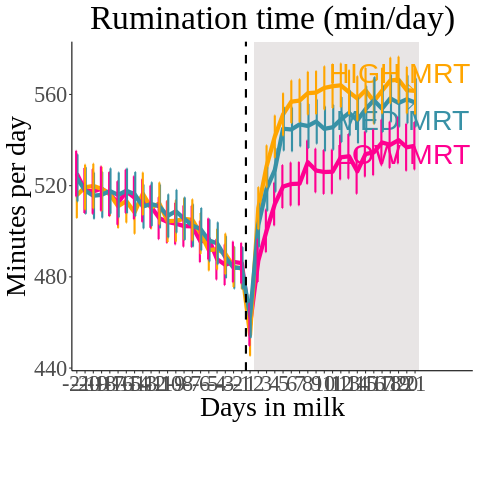

In [ ]:
%%R

p = dfLMSs %>% inner_join(Significance) %>%  mutate(label = if_else(DaysInMilk == max(as.numeric(DaysInMilk)), as.character(MRTQuantile), NA_character_),
                                                    significance = case_when(
                                                        `LOW - HIGH` == "Significant" ~ "Significant",
                                                        `LOW - MED` == "Significant" ~ "Significant",
                                                        `HIGH - MED` == "Significant" ~ "Significant",
                                                        TRUE ~ "Not-Significant"
                                                    )) %>%
  ggplot(
  aes(
    x=DaysInMilk,
    y=emmean,
    group=MRTQuantile,
    color=MRTQuantile)
    ) +
    scale_color_manual(values=group.colors)+
    scale_fill_manual(values=group.colors)+
    scale_alpha_manual(values = c("Not-Significant"=0,"Significant"=0.05))+ # transparency significance rectangles
    geom_rect(aes(xmin=as.numeric(DaysInMilk)-0.5, xmax =as.numeric(DaysInMilk)+0.5,ymin=-Inf,ymax=Inf,fill =significance ,alpha = significance),color = NA )+
    geom_line(size=2) +
    geom_text_repel(data= subset(dfLMSs,DaysInMilk == 21), aes(label = MRTQuantile, colour = MRTQuantile, x = 42, y= emmean),hjust = -0.8, size = 10, nudge_x =7,box.padding = 0.5,direction = "y")+
    geom_errorbar(
    aes(ymin=asymp.LCL,
        ymax=asymp.UCL),
    width=0.25,
    size=1,
    position=position_dodge(0.25)) +
  labs(
    title = "Rumination time (min/day)",
    y="Minutes per day" ,
    x = "Days in milk") +
  theme_bw() +
  theme(text = element_text(family = "Times New Roman"),plot.margin = unit(c(0.5,0.5,4,0.5), "lines")) +
  theme(text=element_text(size=28),
        plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black"))+
  theme (legend.position= "none")+
  geom_vline(xintercept = myLoc, size = 1, linetype= "dashed", color ="black")



gt <- ggplotGrob(p)
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)


In [ ]:
%%R
ggsave(plot = gt,"/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/Figures/RuminationTimeMRTQuantileByDaysInMilk.png", width = 24, height = 8)

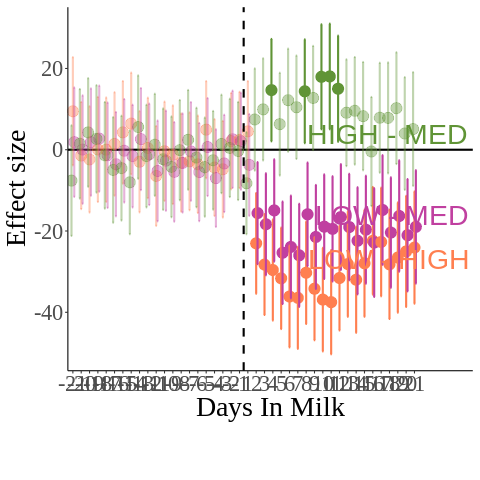

In [ ]:
%%R

myLoc <-
  (which(levels(dfLMSs$DaysInMilk) == "-1") +
     which(levels(dfLMSs$DaysInMilk) == "1")) /
  2

group.colors<-c("HIGH - MED"="#609436", "LOW - MED"="#C040A0", "LOW - HIGH"="#FF7F50","Significant"="#171710")
plotEffectSize <- dfConfInts %>%
  ggplot(
  aes(
    x=DaysInMilk,
    y=estimate,color = contrast)
    ) +
    scale_color_manual(values = group.colors)+
    scale_fill_manual(values = group.colors)+
  geom_hline(yintercept=0, color= "black", size=1) +
  scale_alpha_manual(values = c("Not-Significant"=0.4,"Significant"=1))+ # transparency significance each group
  geom_point(aes(alpha = significance),size=5,position=position_dodge(0.5)) +
  geom_errorbar(
    aes(ymin=asymp.LCL,
        ymax=asymp.UCL,
        alpha = significance),
    position=position_dodge(0.5),
    width=0.5,
    size=1) +
  geom_text_repel(data= subset(dfConfInts,DaysInMilk == 21), aes(label = contrast, colour = contrast, x = 42, y= estimate),hjust = -0.8, size = 10, nudge_x =7,box.padding = 0.5,direction = "y") +
  labs(
    y="Effect size" ,
    x = "Days In Milk") +
  theme_bw() +
  theme(text = element_text(family = "Times New Roman",size =28),
        plot.title = element_blank(),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black"),
        legend.position="none",
        legend.title = element_blank(),
        plot.margin = unit(c(0.5,0.5,4,0.5), "lines"))+
  geom_vline(xintercept = myLoc, size = 1, linetype= "dashed", color ="black")

plotEffectSize

In [ ]:
%%R
ggsave(plot = plotEffectSize,"/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/Figures/RuminatinoTimeMRTQuantileByDaysInMilkeffectPlot.png", width = 24, height = 6)

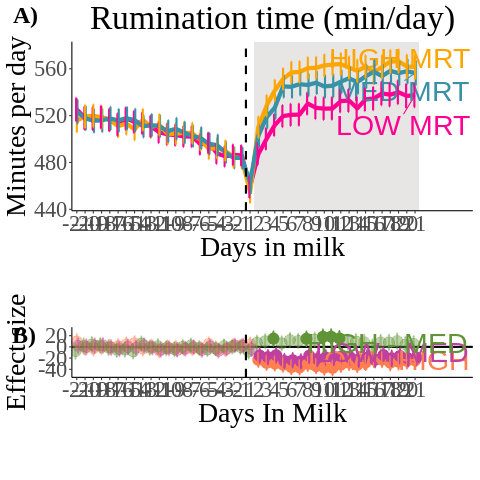

In [ ]:
%%R
combinedPlot <- ggarrange(
    gt,
    plotEffectSize,
    heights = c(2, 1),
    labels = c("A)","B)"),
    ncol = 1,
    nrow = 2,
    align ="v",font.label=list(family = "Times New Roman",size=24))


    combinedPlot

In [ ]:
%%R
ggsave(plot = combinedPlot,"/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/Figures/RuminationTimeMRTQuantileByDaysInMilkCombo.png", width = 24, height = 14)